# roastcoffea: Comprehensive Performance Monitoring for Coffea

This notebook demonstrates all features of roastcoffea including:
- Basic metrics collection
- Chunk-level tracking with `@track_metrics`
- Byte tracking for I/O analysis
- Fine-grained profiling with `track_time()` and `track_memory()`
- Complete visualization suite (17 plot types)

In [ ]:
from contextlib import contextmanager
from pathlib import Path

import awkward as ak
import matplotlib.pyplot as plt
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from dask.distributed import Client, LocalCluster

from roastcoffea import (
    MetricsCollector,
    track_bytes,
    track_memory,
    track_metrics,
    track_time,
)
from roastcoffea.visualization.plots import (
    plot_compression_ratio_distribution,
    plot_cpu_utilization_per_worker_timeline,
    plot_data_access_percentage,
    plot_efficiency_summary,
    plot_executing_tasks_timeline,
    plot_memory_utilization_mean_timeline,
    plot_occupancy_timeline,
    plot_per_task_bytes_read,
    plot_per_task_cpu_io,
    plot_per_task_overhead,
    plot_resource_utilization,
    plot_runtime_distribution,
    plot_runtime_vs_events,
    plot_throughput_timeline,
    plot_total_active_tasks_timeline,
    plot_worker_activity_timeline,
    plot_worker_count_timeline,
)

# Configure matplotlib for inline display
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
@contextmanager
def acquire_client(n_workers=4, threads_per_worker=1):
    """Context manager for Dask client."""
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=threads_per_worker,
        processes=True,
    )
    client = Client(cluster)
    print(f"Dashboard: {client.dashboard_link}")

    try:
        yield client
    finally:
        client.close()
        cluster.close()

In [3]:
@contextmanager
def acquire_client(n_workers=4, threads_per_worker=1):
    """Context manager for Dask client."""
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=threads_per_worker,
        processes=True,
    )
    client = Client(cluster)
    print(f"Dashboard: {client.dashboard_link}")

    try:
        yield client
    finally:
        client.close()
        cluster.close()

## Dataset Setup

Using CERN Open Data for reproducible demonstrations.

In [4]:
fileset = {
    "ttbar": {
        "files": {
            "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root": "Events"
        }
    }
}

## Full Featured Processor

This processor demonstrates all roastcoffea tracking features:
- `@track_metrics`: Automatic chunk-level metrics (timing, memory, bytes)
- `track_bytes()`: Fine-grained I/O tracking for specific data access
- `track_time()`: Time profiling for code sections
- `track_memory()`: Memory profiling for code sections

In [5]:
class ComprehensiveProcessor(processor.ProcessorABC):
    """Processor with all roastcoffea features enabled."""

    @track_metrics
    def process(self, events):
        # Track jet loading I/O
        with track_bytes(self, events, "jet_loading"):
            with track_time(self, "jet_selection"):
                jets = events.Jet
                selected_jets = jets[jets.pt > 30]

        # Track muon loading I/O
        with track_bytes(self, events, "muon_loading"):
            with track_time(self, "muon_selection"):
                muons = events.Muon
                selected_muons = muons[muons.pt > 20]

        # Track memory-intensive computations
        with track_memory(self, "pt_calculations"):
            jet_pt_sum = ak.sum(selected_jets.pt, axis=1)
            muon_pt_sum = ak.sum(selected_muons.pt, axis=1)

        return {
            "nevents": len(events),
            "njets": len(selected_jets),
            "nmuons": len(selected_muons),
        }

    def postprocess(self, accumulator):
        return accumulator

## Run Analysis with Metrics Collection

In [6]:
comprehensive_processor = ComprehensiveProcessor()

with acquire_client(n_workers=4) as client:
    with MetricsCollector(
        client=client,
        processor_instance=comprehensive_processor,
        track_workers=True,
        worker_tracking_interval=1.0,
    ) as collector:
        executor = processor.DaskExecutor(client=client)
        runner = processor.Runner(
            executor=executor,
            schema=NanoAODSchema,
            chunksize=100_000,
            savemetrics=True,
        )

        output, report = runner(
            fileset,
            processor_instance=comprehensive_processor,
            treename="Events",
        )

        # Extract chunk metrics from output
        collector.extract_metrics_from_output(output)
        collector.set_coffea_report(report)

    # Print summary tables
    collector.print_summary()

# Get metrics for plotting
metrics = collector.get_metrics()
tracking_data = collector.tracking_data

/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60990 instead
  warnings.warn(


Dashboard: http://127.0.0.1:60990/status


Output()

Output()

/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/Users/moaly/Work/iris-hep/roastcoffea/.pixi/envs/dev/lib/python3.13/site-packages/coffe

                 Throughput Metrics                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                    ┃ Value                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Data Rate                 │ 0.03 Gbps (3.4 MB/s) │
│ Total Bytes Read (Coffea) │ 43.94 MB             │
│ Memory Read (Dask Spans)  │ 304.99 KB            │
└───────────────────────────┴──────────────────────┘

            Event Processing Metrics            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Total Events               │ 1,233,000       │
│ Event Rate (Wall Clock)    │ 90.1 kHz        │
│ Event Rate (Aggregated)    │ 70.4 kHz        │
│ Event Rate (Core-Averaged) │ 22536.2 Hz/core │
│ Efficiency Ratio           │ 128.1%          │
└────────────────────────────┴─────────────────┘

          Resource Utilization          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                   ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Workers (Time-Averaged)  │ 4.0       │
│ Peak Workers             │ 4         │
│ Cores per Worker         │ 1.0       │
│ Total Cores              │ 4         │
│ Core Efficiency          │ 32.0%     │
│ Speedup Factor           │ 1.3x      │
│ Peak Memory (per worker) │ 376.53 MB │
│ Avg Memory (per worker)  │ 259.01 MB │
└──────────────────────────┴───────────┘

       Timing Breakdown       
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric             ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Wall Time          │ 13.7s │
│ Total CPU Time     │ 17.5s │
│ Number of Chunks   │ 12    │
│ Avg CPU Time/Chunk │ 1.5s  │
└────────────────────┴───────┘

    Fine Metrics (from Dask Spans)    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric                     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Processor CPU Time         │ 9.7s  │
│ Processor Non-CPU Time     │ 22.7s │
│   CPU %                    │ 29.9% │
│   Non-CPU %                │ 70.1% │
│ Dask Overhead CPU Time     │ 0.4s  │
│ Dask Overhead Non-CPU Time │ 1.6s  │
└────────────────────────────┴───────┘

         Chunk Metrics          
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric            ┃ Value    ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total Chunks      │ 12       │
│ Mean Chunk Time   │ 1.5s     │
│   • Min           │ 1.0s     │
│   • Max           │ 2.5s     │
│   • Std Dev       │ 0.4s     │
│ Mean Memory Delta │ 18.2 MB  │
│   • Min           │ -46.5 MB │
│   • Max           │ 44.8 MB  │
│ Mean Events/Chunk │ 102750   │
│   • Min           │ 102750   │
│   • Max           │ 102750   │
└───────────────────┴──────────┘

## Performance Visualizations

roastcoffea provides 17 different plot types organized into categories:

### 1. Throughput & Data I/O
### 2. Worker Resource Utilization
### 3. Chunk-level Analysis
### 4. Per-Task Analysis
### 5. Summary Metrics

### Throughput & Data I/O

Track data processing rates, I/O patterns, file compression, and data access efficiency.

📊 Data Throughput Over Time


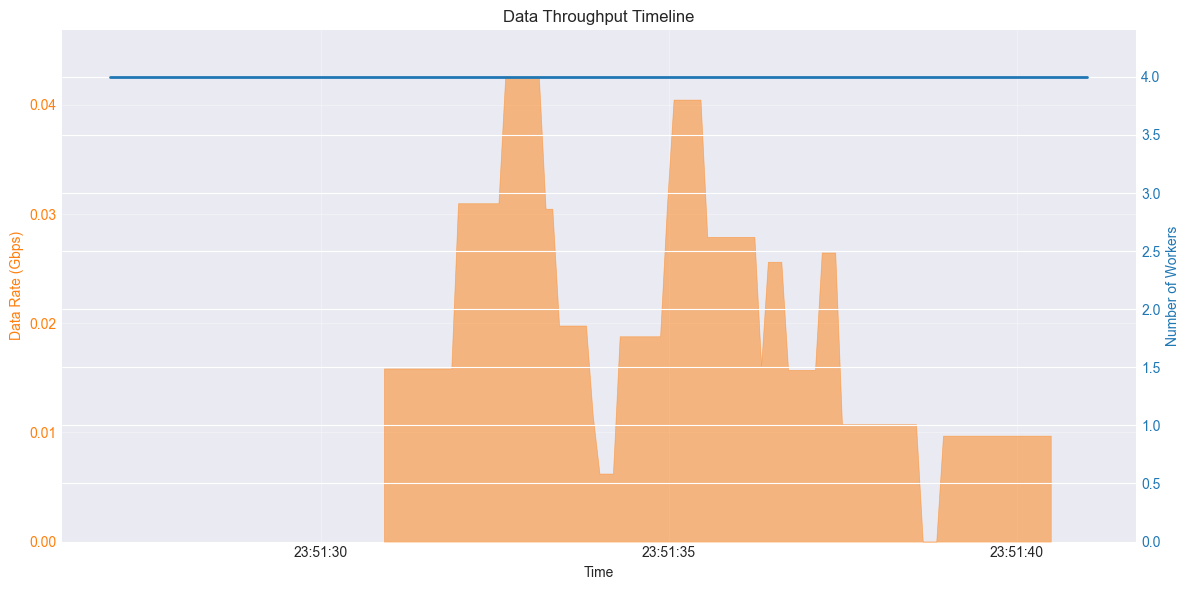

In [7]:
# Data Throughput Timeline (requires byte tracking)
if metrics.get("chunk_info"):
    print("📊 Data Throughput Over Time")
    fig, ax = plot_throughput_timeline(
        chunk_info=metrics["chunk_info"],
        tracking_data=tracking_data,
        title="Data Throughput Timeline",
    )
    plt.show()
else:
    print(
        "⚠️  Byte tracking not available. Throughput plot requires @track_metrics decorator."
    )

📊 Compression Ratio Distribution Across Files
   Shows compression efficiency (compressed/uncompressed)


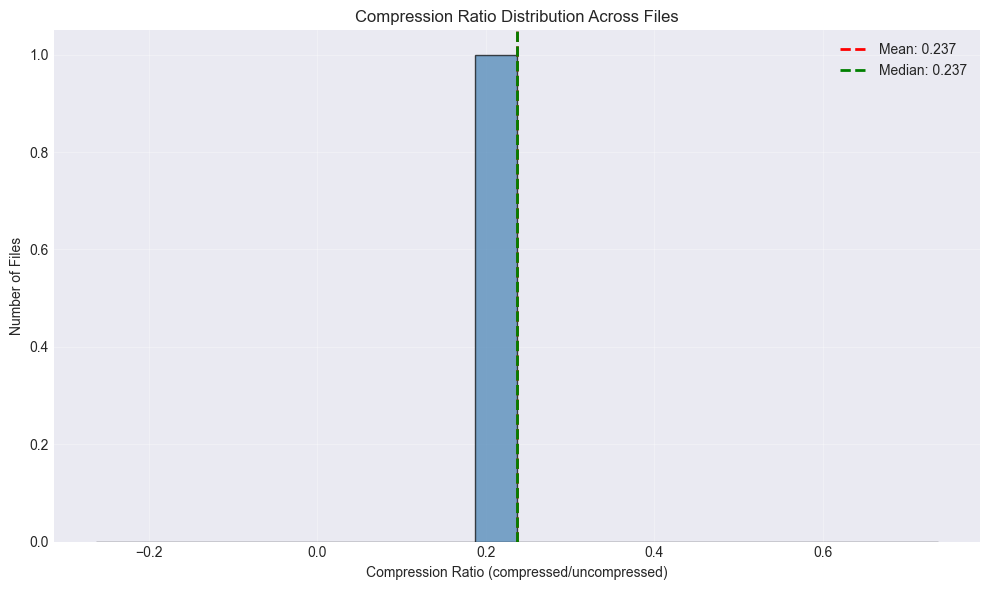

In [8]:
# Compression Ratio Distribution
if metrics.get("compression_ratios"):
    print("📊 Compression Ratio Distribution Across Files")
    print("   Shows compression efficiency (compressed/uncompressed)")
    try:
        fig, ax = plot_compression_ratio_distribution(metrics)
        plt.show()
    except Exception as e:
        print(f"   Plot unavailable: {e}")
else:
    print("⚠️  Compression ratio data not available")

📊 Bytes Read Percentage Distribution
   Shows what % of each file's bytes were actually read


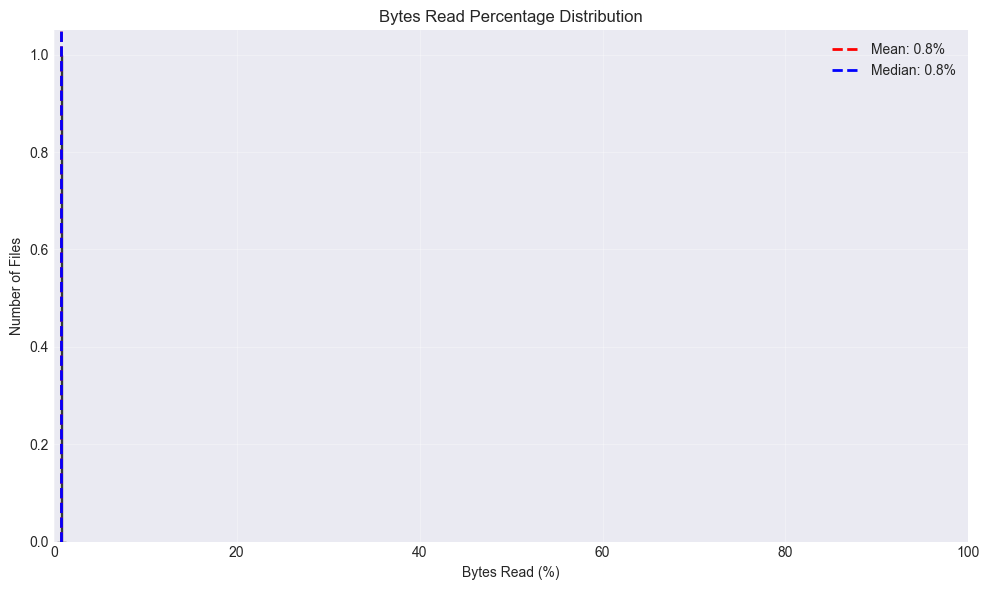

In [9]:
# Bytes Read Percentage Distribution
if metrics.get("bytes_read_percent_per_file"):
    print("📊 Bytes Read Percentage Distribution")
    print("   Shows what % of each file's bytes were actually read")
    try:
        fig, ax = plot_data_access_percentage(metrics)
        plt.show()
    except Exception as e:
        print(f"   Plot unavailable: {e}")
else:
    print("⚠️  Bytes read percentage data not available")

### Worker Resource Utilization

Monitor worker activity, task distribution, and resource usage.

📊 Worker Count Over Time


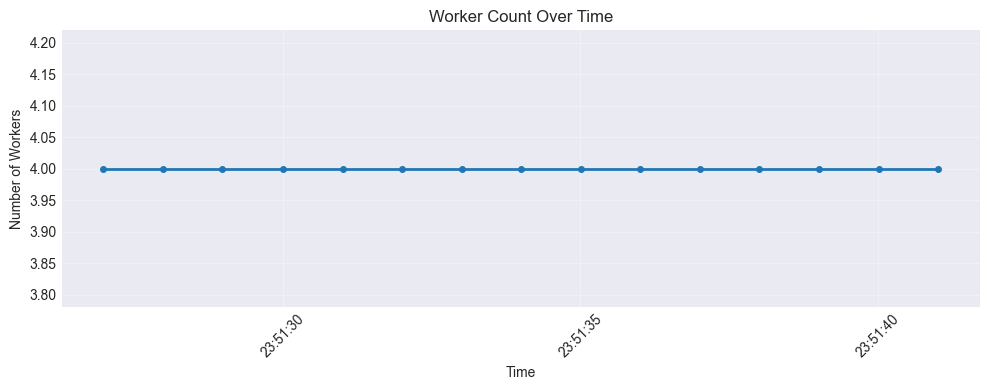

In [10]:
# Worker Count Over Time
if tracking_data and "worker_counts" in tracking_data:
    print("📊 Worker Count Over Time")
    fig, ax = plot_worker_count_timeline(tracking_data)
    plt.show()

📊 Worker Activity Timeline
   Shows active (processing + queued) tasks per worker


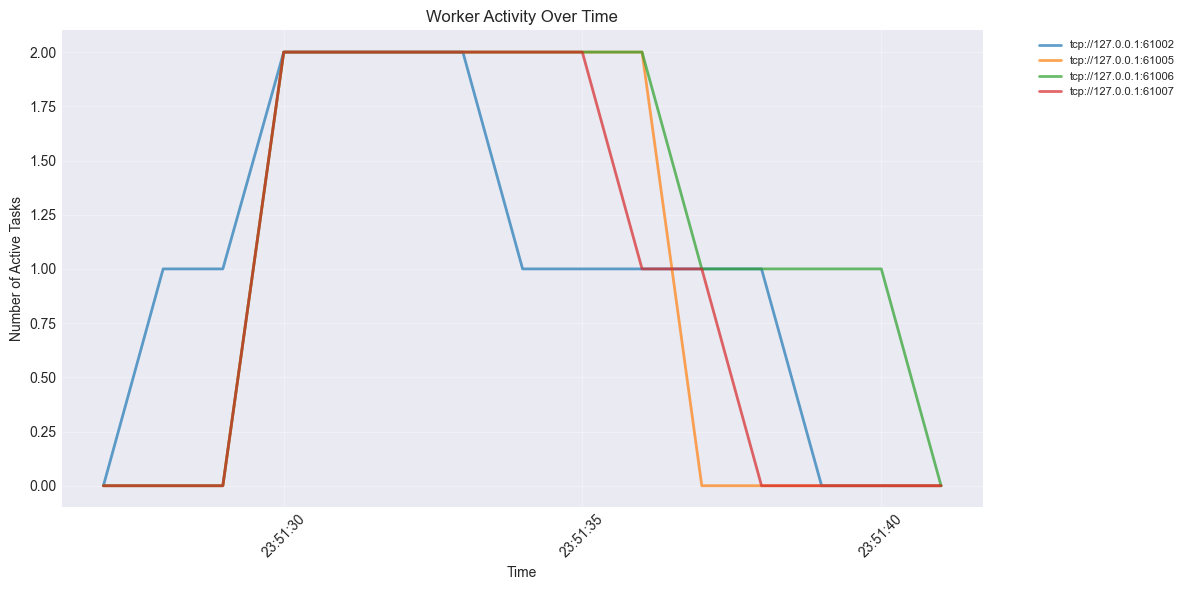

In [11]:
# Worker Activity Timeline (active tasks per worker)
if tracking_data and "worker_active_tasks" in tracking_data:
    print("📊 Worker Activity Timeline")
    print("   Shows active (processing + queued) tasks per worker")
    fig, ax = plot_worker_activity_timeline(
        tracking_data,
        max_legend_entries=5,  # Hide legend if >5 workers
    )
    plt.show()

📊 Total Active Tasks Across All Workers


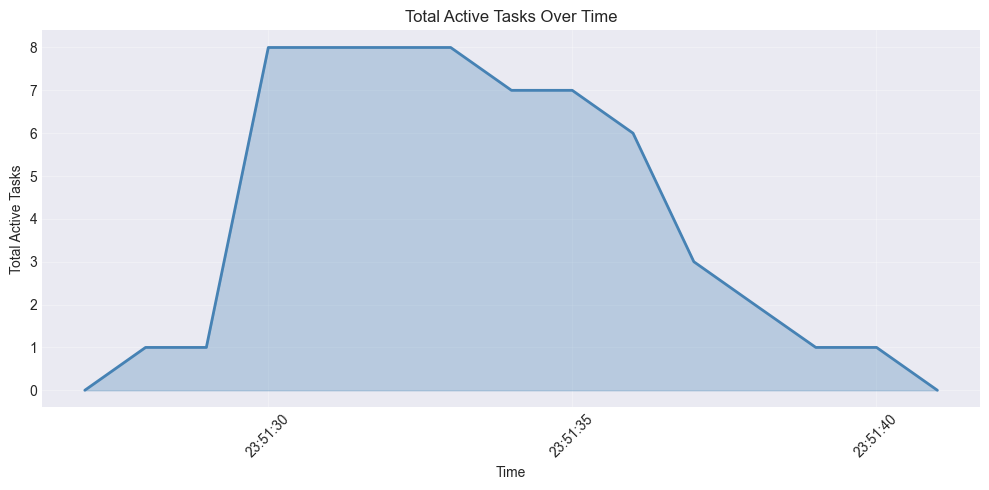

In [12]:
# Total Active Tasks Across All Workers
if tracking_data and "worker_active_tasks" in tracking_data:
    print("📊 Total Active Tasks Across All Workers")
    fig, ax = plot_total_active_tasks_timeline(tracking_data)
    plt.show()

📊 Worker Occupancy (Task Saturation)
   0.0 = idle, higher values = more saturated


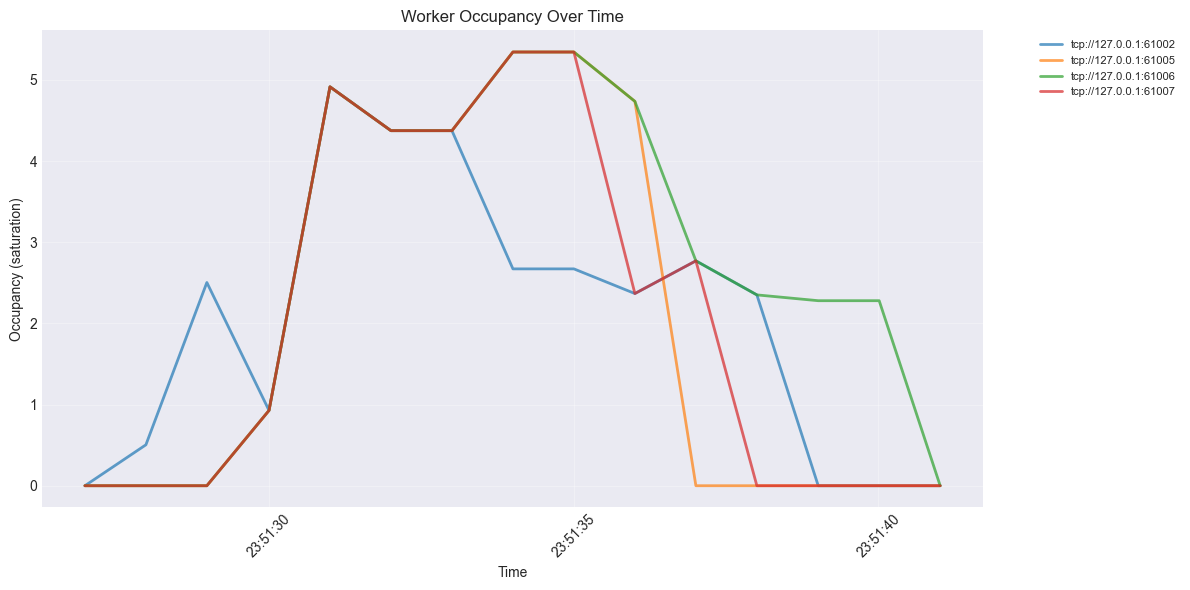

In [13]:
# Worker Occupancy (task saturation)
if tracking_data and "worker_occupancy" in tracking_data:
    print("📊 Worker Occupancy (Task Saturation)")
    print("   0.0 = idle, higher values = more saturated")
    fig, ax = plot_occupancy_timeline(tracking_data, max_legend_entries=5)
    plt.show()

📊 Executing Tasks Per Worker
   Shows tasks actually running (subset of active tasks)


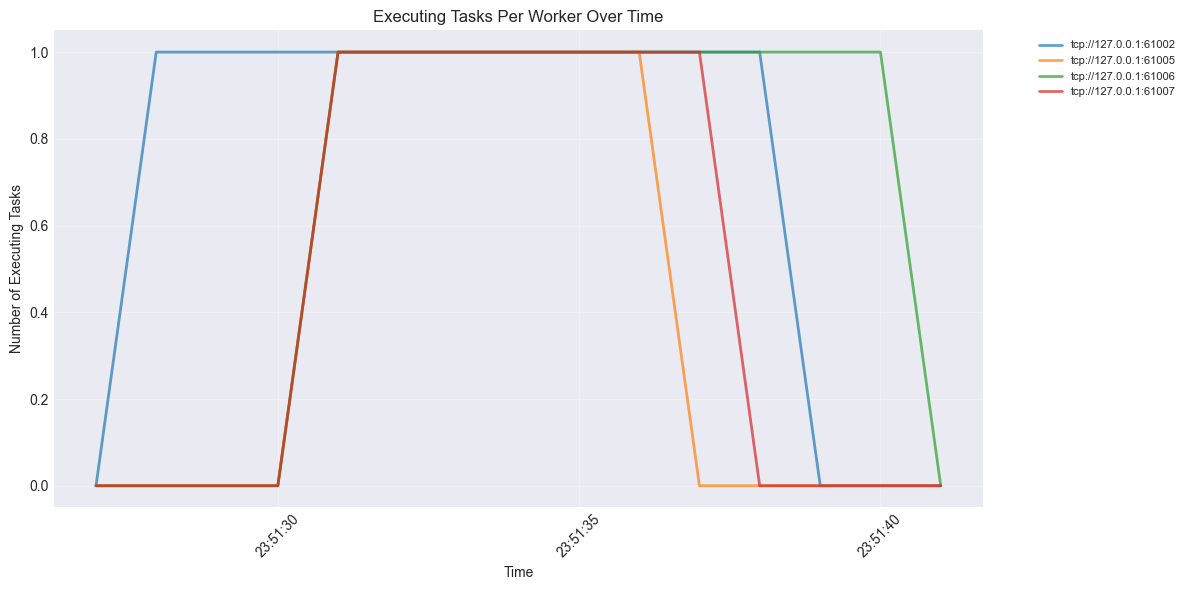

In [14]:
# Executing Tasks Per Worker
if tracking_data and "worker_executing" in tracking_data:
    print("📊 Executing Tasks Per Worker")
    print("   Shows tasks actually running (subset of active tasks)")
    fig, ax = plot_executing_tasks_timeline(tracking_data, max_legend_entries=5)
    plt.show()

In [ ]:
# Memory Utilization
if tracking_data and "worker_memory" in tracking_data:
    print("📊 Memory Utilization (Mean Across Workers)")
    fig, ax = plot_memory_utilization_mean_timeline(tracking_data)
    plt.show()

In [ ]:
# CPU Utilization Per Worker
if tracking_data and "worker_cpu" in tracking_data:
    print("📊 CPU Utilization Per Worker")
    print("   Shows CPU usage percentage (0-100%) for each worker")
    fig, ax = plot_cpu_utilization_per_worker_timeline(
        tracking_data, max_legend_entries=5
    )
    plt.show()

### Chunk-level Analysis

Performance metrics for individual chunks (runtime, events processed).

📊 Chunk Runtime Distribution
   Histogram of processing time per chunk


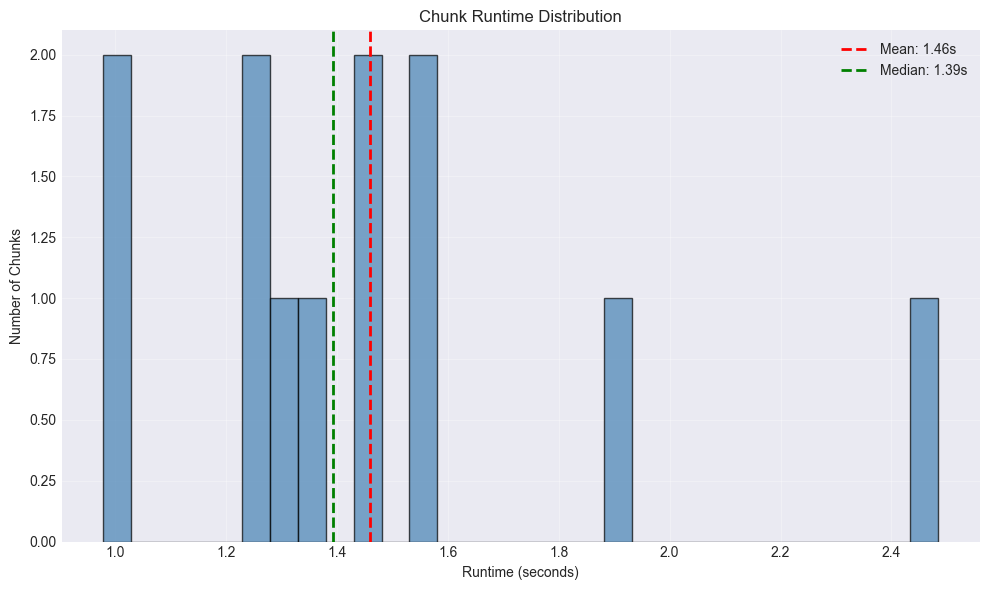

In [17]:
# Chunk Runtime Distribution
if metrics.get("raw_chunk_metrics"):
    print("📊 Chunk Runtime Distribution")
    print("   Histogram of processing time per chunk")
    try:
        fig, ax = plot_runtime_distribution(chunk_metrics=metrics["raw_chunk_metrics"])
        plt.show()
    except Exception as e:
        print(f"   Plot unavailable: {e}")
else:
    print("⚠️  Chunk metrics not available")

📊 Chunk Runtime vs Number of Events
   Scatter plot showing scaling behavior


/Users/moaly/Work/iris-hep/roastcoffea/src/roastcoffea/visualization/plots/chunks.py:158: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(events, runtimes, 1)


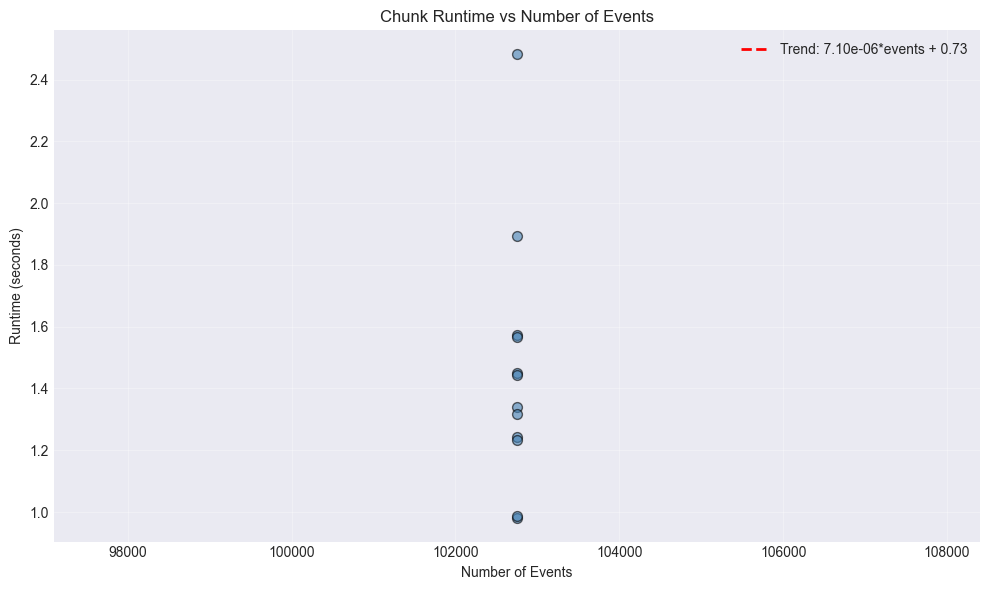

In [18]:
# Chunk Runtime vs Number of Events
if metrics.get("raw_chunk_metrics"):
    print("📊 Chunk Runtime vs Number of Events")
    print("   Scatter plot showing scaling behavior")
    try:
        fig, ax = plot_runtime_vs_events(chunk_metrics=metrics["raw_chunk_metrics"])
        plt.show()
    except Exception as e:
        print(f"   Plot unavailable: {e}")
else:
    print("⚠️  Chunk metrics not available")

### Per-Task Analysis

Fine-grained metrics from Dask Spans for individual task performance.

📊 Per-Task CPU vs I/O Time


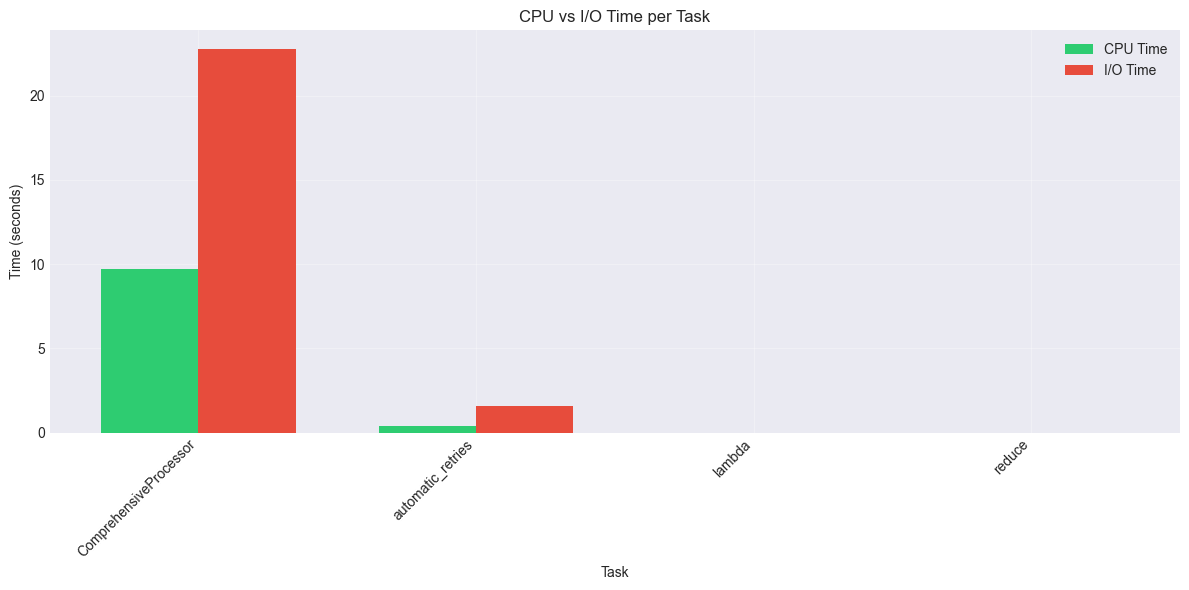

In [19]:
span_metrics = getattr(collector, "span_metrics", None)

if span_metrics:
    # CPU vs I/O Breakdown
    print("📊 Per-Task CPU vs I/O Time")
    try:
        fig, ax = plot_per_task_cpu_io(span_metrics)
        plt.show()
    except Exception as e:
        print(f"   Plot unavailable: {e}")
else:
    print("⚠️  Span metrics not available")

In [20]:
if span_metrics:
    # Bytes Read Per Task
    print("📊 Per-Task Bytes Read")
    try:
        fig, ax = plot_per_task_bytes_read(span_metrics)
        plt.show()
    except Exception as e:
        print(f"   Plot unavailable: {e}")

📊 Per-Task Bytes Read
   Plot unavailable: No per-task disk-read metrics found in span_metrics


In [21]:
if span_metrics:
    # Compression & Serialization Overhead
    print("📊 Per-Task Compression & Serialization Overhead")
    try:
        fig, ax = plot_per_task_overhead(span_metrics)
        plt.show()
    except Exception as e:
        print(f"   Plot unavailable: {e}")

📊 Per-Task Compression & Serialization Overhead
   Plot unavailable: No per-task overhead metrics found in span_metrics


### Summary Metrics

High-level overview of overall performance.

📊 Efficiency Summary


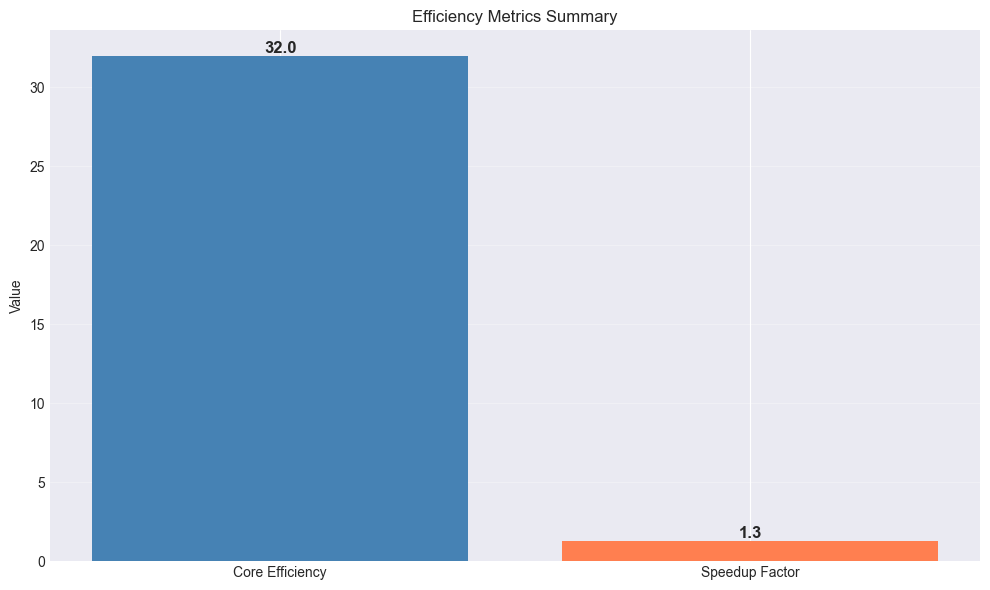

In [22]:
# Efficiency Summary
print("📊 Efficiency Summary")
fig, ax = plot_efficiency_summary(metrics)
plt.show()

📊 Resource Utilization


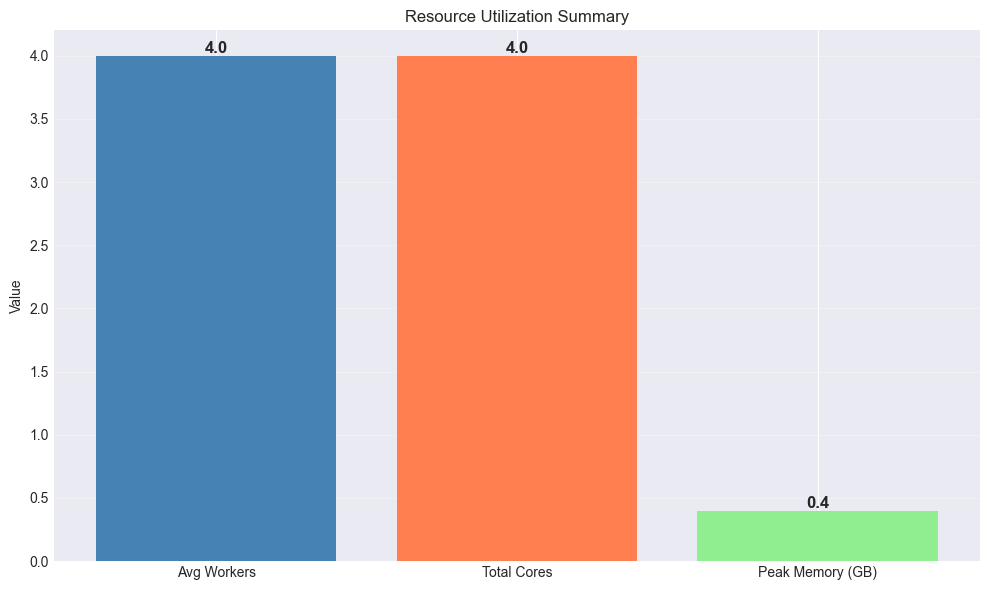

In [23]:
# Resource Utilization Summary
print("📊 Resource Utilization")
fig, ax = plot_resource_utilization(metrics)
plt.show()

## Accessing Raw Metrics

All metrics are accessible programmatically for custom analysis.

In [24]:
# Overall metrics
print("=" * 60)
print("KEY METRICS")
print("=" * 60)
print(f"Total events: {metrics.get('total_events', 0):,}")
print(f"Total bytes read: {metrics.get('total_bytes_read_coffea', 0) / 1e9:.2f} GB")
print(f"Overall throughput: {metrics.get('overall_rate_gbps', 0):.2f} Gbps")
print(f"Wall time: {metrics.get('wall_time', 0):.2f}s")
print(f"Core efficiency: {metrics.get('core_efficiency', 0):.1f}%")
print(f"Number of chunks: {metrics.get('num_chunks', 0)}")

KEY METRICS
Total events: 1,233,000
Total bytes read: 0.05 GB
Overall throughput: 0.03 Gbps
Wall time: 13.68s
Core efficiency: 0.3%
Number of chunks: 12


In [ ]:
# Per-chunk metrics (if available)
if "raw_chunk_metrics" in metrics:
    print("\n" + "=" * 60)
    print("CHUNK-LEVEL DETAILS (first 3 chunks)")
    print("=" * 60)
    for i, chunk in enumerate(metrics["raw_chunk_metrics"][:3]):
        print(f"\nChunk {i + 1}:")
        print(f"  Events: {chunk.get('num_events', 0):,}")
        print(f"  Duration: {chunk.get('duration', 0):.2f}s")
        print(f"  Bytes read: {chunk.get('bytes_read', 0) / 1e6:.2f} MB")
        print(f"  Memory delta: {chunk.get('mem_delta_mb', 0):+.1f} MB")

        # Fine-grained timing
        if chunk.get("timing"):
            print("  Timing breakdown:")
            for section, duration in chunk["timing"].items():
                print(f"    {section}: {duration:.3f}s")

        # Fine-grained bytes
        if chunk.get("bytes"):
            print("  I/O breakdown:")
            for section, bytes_count in chunk["bytes"].items():
                print(f"    {section}: {bytes_count / 1e6:.2f} MB")


CHUNK-LEVEL DETAILS (first 3 chunks)

Chunk 1:
  Events: 102,750
  Duration: 1.57s
  Bytes read: 1.91 MB
  Memory delta: +19.3 MB
  Timing breakdown:
    jet_selection: 1.102s
    muon_selection: 0.455s
  I/O breakdown:
    jet_loading: 1.46 MB
    muon_loading: 0.44 MB

Chunk 2:
  Events: 102,750
  Duration: 1.24s
  Bytes read: 1.88 MB
  Memory delta: +42.6 MB
  Timing breakdown:
    jet_selection: 0.740s
    muon_selection: 0.487s
  I/O breakdown:
    jet_loading: 1.44 MB
    muon_loading: 0.44 MB

Chunk 3:
  Events: 102,750
  Duration: 1.57s
  Bytes read: 1.94 MB
  Memory delta: +22.3 MB
  Timing breakdown:
    jet_selection: 0.781s
    muon_selection: 0.770s
  I/O breakdown:
    jet_loading: 1.49 MB
    muon_loading: 0.45 MB


## Saving & Loading Measurements

Persist metrics for later analysis or comparison.

In [26]:
# Save measurement
output_dir = Path("measurements")
measurement_path = collector.save_measurement(
    output_dir, measurement_name="comprehensive_demo"
)
print(f"✅ Saved to: {measurement_path}")

✅ Saved to: measurements/comprehensive_demo


In [29]:
# Load it back
from roastcoffea.export.measurements import load_measurement

metrics, t0, t1 = load_measurement(measurement_path)
print(f"✅ Loaded metrics from {measurement_path}")
print(f"   Events processed: {metrics['total_events']:,}")
print(f"   Throughput: {metrics['overall_rate_gbps']:.2f} Gbps")
print(f"   Wall time: {t1 - t0:.1f}s")

✅ Loaded metrics from measurements/comprehensive_demo
   Events processed: 1,233,000
   Throughput: 0.03 Gbps
   Wall time: 13.7s
